Basic setup

In [2]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')



### Key Concepts

- **Arrays and tensors**: Representation of data in a computer.
- **Broadcasting**: Powerful technique for manipulating arrays.
- **Stochastic gradient descent (SGD)**: Algorithm for weight updates during learning.
- **Loss function**: Measures model performance for classification tasks.
- **Mini-batches**: Dividing training data into smaller chunks for efficiency.
- **Neural network math**: Understanding the core calculations.

#### MNIST Dataset

- Introduction to MNIST dataset: Handwritten digits.
- Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.


For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. So let's download a sample of MNIST that contains images of just these digits

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/Users/wenda/.fastai/data/mnist_sample')

In [4]:
"""We can see what's in this directory by using ls, a method added by fastai. 
This method returns an object of a special fastai class called L, 
which has all the same functionality of Python's built-in list, plus a lot more. 
One of its handy features is that, when printed, it displays the count of items, 
before listing the items themselves (if there are more than 10 items, it just shows the first few):

"""

Path.BASE_PATH = path
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [5]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [6]:
"""There's a folder of 3s, and a folder of 7s. 
In machine learning parlance, we say that "3" and "7" are the labels (or targets) in this dataset. 
Let's take a look in one of these folders (using sorted to ensure we all get the same order of files):"""


threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

**Working with Images in Python**

*Using Python Imaging Library (PIL) for image manipulation*

* **PIL Image Class:**
    * Most widely used Python package for opening, manipulating, and viewing images.
    * Jupyter notebooks can automatically display images loaded using PIL.

* **Image Data Representation:**
    * On computers, everything is stored as numbers.
    * To access the numerical representation of an image, we need to convert it to a NumPy array or a PyTorch tensor.


In [8]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

The 4:10 indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns. NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image. Here's the same thing as a PyTorch tensor:

In [9]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:



In [10]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')
 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


**Understanding an Image for a Computer**

* Background white pixels are stored as 0.
* Black pixels are stored as 255.
* Shades of gray have values between 0 and 255.
* This image has 28x28 pixels (784 total).

**Goal: Digit Recognition (3s and 7s)**

**Challenge: How to achieve recognition?**

**Stop and Think** (before continuing):

* Brainstorm features a computer can analyze in the image (3 vs 7).
* Consider methods for identifying these features.
* Imagine how the computer might combine these features for recognition.
---


### Method 1: Pixel Similarity as a Baseline for Digit Classification

* **Idea:** Compare the average pixel value of an image to the average pixel value of known digits (e.g., 3s and 7s) for classification.
* **Baseline Model:** This is a simple approach to serve as a benchmark for more complex models.

**What is a baseline model?**
* Baseline: A basic model expected to perform reasonably well. It should be easy to implement and evaluate to measure the effectiveness of more advanced models.

**Steps:**

1. **Calculate Average Pixel Value:**
    * Group training images by digit (e.g., all 3s together).
    * Calculate the average pixel value for each group.

**Learning Python Techniques:**

* Creating a tensor containing all images from a directory using list comprehension.
* Performing checks throughout the process (e.g., verifying the number of images matches expectations).


In [11]:

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

#### List Comprehensions in Python

* **Powerful feature for creating lists and dictionaries.**
* **Commonly used by Python programmers.**
* **Alternative to traditional for loops.**

**Basic Syntax:**

```
new_list = [f(o) for o in a_list if o > 0]
```

**Explanation:**

* Iterates over a collection (`a_list`).
* Applies an optional filter (`if o > 0`).
* Performs an operation (`f(o)`) on each element that passes the filter.
* Creates a new list with the transformed elements.

**Benefits:**

* Concise and readable code.
* Improved performance compared to for loops.

**Additional Notes:**

* List comprehensions can also be used for dictionary creation.
* Many tutorials available online for further exploration.

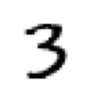

In [12]:
"""We'll also check that one of the images looks okay. 
Since we now have tensors (which Jupyter by default will print as values), 
rather than PIL images (which Jupyter by default will display as images), we need to use fastai's show_image function to display it:"""

show_image(three_tensors[1]);

Computing Average Pixel Intensity Across Images

* **Goal:** Calculate the average intensity of each pixel across a set of images.
* **Process:**
    1. **Combine Images:** 
        * Stack individual image tensors into a single rank-3 tensor using `torch.stack`.
    2. **Cast to Float:**
        * Convert the tensor's data type from integer to float using type casting (`float()`). This is necessary for some operations like calculating the mean.
    3. **Normalize Intensity (Optional):**
        * Divide the tensor by 255 (assuming pixel values are between 0 and 1) for normalization.

**Note:** This approach assumes all images have the same dimensions (width and height).


In [13]:
"""Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:"""
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape
     

torch.Size([6131, 28, 28])

Tensor Shape in PyTorch

* **Key Attribute:** Shape of a tensor determines the length of each axis.
* **Example:** Tensor with 6,131 images, each 28x28 pixels.
* **Interpretation:** 
    * 1st axis (length): Number of images (6,131)
    * 2nd axis (height): Image height (28 pixels)
    * 3rd axis (width): Image width (28 pixels)
* **Semantic Meaning:** Defined during tensor creation, not inherent in the data.
* **PyTorch View:** A tensor is just a collection of numbers in memory.

The *length* of a tensor's shape is its rank: 

In [14]:
len(stacked_threes.shape)

3

#### Tensor Jargon - Key Points

* **Rank vs. Shape:**
    * Rank: Number of axes or dimensions in a tensor (analogous to the number of coordinates needed to specify a point in space).
    * Shape: Size of each axis of a tensor (specifies the length of each dimension).

* **Dimension Ambiguity:**
    * Term "dimension" can have two meanings:
        * Size of an axis (e.g., "space is three-dimensional").
        * Rank of a tensor (number of axes, e.g., "a matrix has two dimensions").
    * To avoid confusion, clarify using rank, axis, and length.

* **Rank Access:**
    * `ndim` attribute directly provides the rank of a tensor in PyTorch. 

**Example (PyTorch):**

A 3D vector `v` might have a length of 3 along a single axis, but `v.ndim` would be 1 (rank one tensor). This clarifies the difference between the number of axes (rank) and the size of that single axis (length).


In [15]:
#We can also get a tensor's rank directly with ndim:
stacked_threes.ndim

3

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

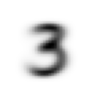

In [16]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

According to this dataset, this is the ideal number 3! (You may not like it, but this is what peak number 3 performance looks like.) You can see how it's very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree.

Let's do the same thing for the 7s, but put all the steps together at once to save some time:

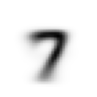

In [17]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

**Let's now pick an arbitrary 3 and measure its distance from our "ideal digits."**

***Stop and Think!**: How would you calculate how similar a particular image is to each of our ideal digits? Remember to step away from this book and jot down some ideas before you move on! Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself*

Here's a sample 3:

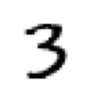

In [18]:
a_3 = stacked_threes[1]
show_image(a_3);

Measuring Distance from Ideal Digit in Images

* **Problem:** Adding pixel differences can be misleading due to positive and negative values cancelling each other out.

* **Solutions for Measuring Distance:**

  * **Mean Absolute Difference (L1 Norm):**
      * Takes the mean (average) of the absolute values of the differences between image pixels and ideal digit pixels.
      * Absolute value ensures all differences are positive.

  * **Root Mean Squared Error (RMSE) or L2 Norm:**
      * Takes the mean of the squared differences between image pixels and ideal digit pixels.
      * Squaring makes all differences positive.
      * Takes the square root to undo the squaring effect.

In [19]:
# Let's try both of these now:


dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
print(dist_3_abs,dist_3_sqr)

dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
print(dist_7_abs,dist_7_sqr)

tensor(0.1114) tensor(0.2021)
tensor(0.1586) tensor(0.3021)


In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as loss functions. You'll find these inside torch.nn.functional, which the PyTorch team recommends importing as F (and is available by default under that name in fastai):

In [20]:
print(F.l1_loss(a_3.float(),mean3), F.mse_loss(a_3,mean3).sqrt())
print(F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt())

tensor(0.1114) tensor(0.2021)
tensor(0.1586) tensor(0.3021)


#### L1 vs. MSE Loss Functions in Machine Learning

* **L1 Loss (Mean Absolute Error):**
    * Represents the average of the absolute differences between predicted and actual values.
    * Less harshly penalizes larger errors compared to MSE.
    * Through code: `(a-b).abs().mean()`, where a and b are tensors

* **MSE Loss (Mean Squared Error):**
    * Represents the average of the squared differences between predicted and actual values.
    * Penalizes larger errors more heavily than L1 loss.

* **Key Takeaway:**
    * Complex mathematical concepts can often be implemented with simple code. 

### NumPy Arrays vs. PyTorch Tensors

* **Speed:** Both NumPy arrays and PyTorch tensors are significantly faster than pure Python for numerical computations due to their underlying C implementations.

* **NumPy Arrays:**
    * Multidimensional table of data with all items of the same type.
    * Can be jagged arrays (arrays of arrays with different inner array sizes).
    * Supports various data types.
    * Wide variety of operators and methods for efficient computations.

* **PyTorch Tensors:**
    * Similar to NumPy arrays but with stricter data type requirements (must be a single basic numeric type).
    * Always a regular shaped multidimensional rectangular structure.
    * Can reside on the GPU for faster computations with large datasets.
    * Enables automatic calculation of derivatives for deep learning applications.

* **Key takeaway:** Effectively using array/tensor APIs is a crucial skill for scientific computing and deep learning in Python.


In [21]:
# To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to array() or tensor():
data = [[1,2,3],[4,5,6]]
arr = array (data)

print(arr)

[[1 2 3]
 [4 5 6]]


In [22]:
tns = tensor(data)
print(tns)

tensor([[1, 2, 3],
        [4, 5, 6]])


In [23]:
#You can select a row (note that, like lists in Python, tensors are 0-indexed so 0 refers to the first row/column):
print("row:",tns[0])
print("column:",tns[:,0])

row: tensor([1, 2, 3])
column: tensor([1, 4])


In [24]:
# You can combine these with Python slice syntax ([start:end] with end being excluded) to select part of a row or column:
print("First row, values from 1st to 2nd column: ",tns[1,0:2])
print("Second row, values from 2nd to 4th column: ",tns[1,1:3])

First row, values from 1st to 2nd column:  tensor([4, 5])
Second row, values from 2nd to 4th column:  tensor([5, 6])


In [25]:
#And you can use the standard operators such as +, -, *, /:
print("Adding one: ", tns+1)
print("Subtracting one: ", tns-1)
print("Multiplying by two: ", tns*2)
print("Dividing by two: ", tns/2)

Adding one:  tensor([[2, 3, 4],
        [5, 6, 7]])
Subtracting one:  tensor([[0, 1, 2],
        [3, 4, 5]])
Multiplying by two:  tensor([[ 2,  4,  6],
        [ 8, 10, 12]])
Dividing by two:  tensor([[0.5000, 1.0000, 1.5000],
        [2.0000, 2.5000, 3.0000]])


In [26]:
# type of tensor
tns.type()

'torch.LongTensor'

In [27]:
# And will automatically change type as needed, for example from int to float:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

Now, lets figure out how is the performance of our baseline model

#### Computing Metrics Using Broadcasting

* **Metrics:** Numbers calculated based on model predictions and true labels to evaluate model performance.
* **Examples:** Mean squared error, mean absolute error. (Less interpretable for most people)
* **Classification Models:** Accuracy is commonly used as the metric.
* **Validation Set:** Used to avoid overfitting (model performing well only on training data).
* **MNIST Dataset:** Includes a separate validation set directory (`valid`).
* **Creating Tensors:** Use tensors from the validation set to calculate metrics for the first-try model (measures distance from ideal image).


In [28]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Key Points on Image Classification with Distance Metrics

* **Checking Shapes:** It's important to verify the shapes of tensors before working with them.

* **Data Summary:**
    * We have two validation sets:
        * 3s validation set: 1,010 images of size 28x28.
        * 7s validation set: 1,028 images of size 28x28.

* **Goal:** Develop a function `is_3` to classify an image as a 3 or a 7.

* **Classification Approach:**
    * The function will compare the unknown image to "ideal digit" representations of 3 and 7.
    * The image will be classified based on its closeness (distance) to one of the ideal digits.

* **Distance Metric:** We need a function to calculate the distance between two images.


In [29]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

mnist_distance(a_3, mean3)

tensor(0.1114)

Calculating Distance Efficiently for Image Classification
* **Previously Calculated Distance:** We have already calculated the distance between a single image (`a_3`) and the ideal digit (`mean3`).

* **Challenge:** Efficient distance calculation for all validation images.
    * Looping through each image in the validation set (`valid_3_tens`) can be inefficient.

* **Broadcasting:** There's a more efficient approach using broadcasting.
    * We can directly pass the entire validation set tensor (`valid_3_tens`) to the distance function.

* **Tensor Shape and Broadcasting:**
    * `valid_3_tens` has a shape of [1010, 28, 28], representing 1010 images.
    * The distance function can calculate the distance between each image in the validation set and the ideal digit simultaneously using broadcasting.


In [30]:

valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

- The code `valid_3_dist = mnist_distance(valid_3_tens, mean3)` calculates the distance between each image in the validation set of digit 3 (`valid_3_tens`) and the mean of digit 3 (`mean3`).
- Instead of raising an error for shape mismatch, it returns the distances for every image as a vector (rank-1 tensor) with a length of 1,010 (the number of digit 3 images in the validation set).
- This is due to broadcasting, where PyTorch automatically expands tensors with different ranks to have the same size, making tensor operations easier to write.
- PyTorch applies the operation on each corresponding element of the two tensors after broadcasting, resulting in a tensor with the same rank as the input tensors.

In [31]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

So in this case, PyTorch treats `mean3`, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set. 

What shape would you expect this tensor to have? Try to figure it out yourself before you look at the answer below:

In [32]:

(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

- The expression `(valid_3_tens-mean3).shape` calculates the difference between the "ideal 3" and each of the 1,010 3s in the validation set, for each of the 28x28 images, resulting in a tensor shape of [1010, 28, 28].
- PyTorch implements broadcasting efficiently without copying the tensor multiple times, utilizing C or CUDA for fast computation.
- Broadcasting and elementwise operations in PyTorch are crucial for efficient code and can be millions of times faster on GPU compared to pure Python.
- The `abs` function applied in `mnist_distance` operates elementwise on the tensor, returning a tensor of absolute values for each element.
- Using `mean((-1,-2))` in `mnist_distance` calculates the mean over the last two axes of the tensor, representing the horizontal and vertical dimensions of the image, resulting in a final tensor size of (1010).
- Broadcasting will be further covered in the book, with regular practice to reinforce understanding.
- The `mnist_distance` function can determine whether an image is a 3 or not by comparing the distance between the image and the ideal 3 with the distance to the ideal 7, utilizing broadcasting and elementwise operations automatically.


In [33]:
# This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

# testing the function on an example:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Note that when we convert the Boolean response to a float, we get 1.0 for True and 0.0 for False. 


In [34]:
# Thanks to broadcasting, we can also test it on the full validation set of 3s:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [35]:
# Now we can calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:


accuracy_3s = is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

**Observations:**
- Achieved over 90% accuracy on both digit 3s and 7s.
- Used broadcasting to define a metric conveniently.
- Acknowledges that digits 3s and 7s are different-looking and only classifying 2 out of 10 possible digits.
- Intends to improve by implementing a system capable of automatic modification to enhance performance.
- Next step is to discuss the training process and Stochastic Gradient Descent (SGD).


---


## Stochastic Gradient Descent (SGD)

**Learning from Experience: Key to Machine Learning**

* Arthur Samuel's description of machine learning from Chapter Introduction:
  * *Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.*
* Pixel similarity approach lacks the ability to learn and improve based on experience.

**Introducing Weights and SGD**

*  Our goal: Develop a model that learns by adjusting weights based on performance.
*  Instead of pixel similarity, we will assign weights to each pixel for each category.
    * Higher weight for pixels likely to be activated for a specific category.
    * **Further explaination: Pixel-based Approach for Image Recognition:**
      - Rather than comparing images to an "ideal image," consider individual pixel weights.
      - Assign weights to each pixel based on its likelihood to represent a certain category.
      - Example: Pixels in the bottom right might have low weight for '7' but high weight for '8'.
      - Represented as a function with weight values for each category (e.g., probability of being the number '8').

**Example: Classifying Eights**

  `def pr_eight(x,w): return (x*w).sum()`
* Function `pr_eight(x, w)`: Calculates the probability of an image being an 8.
    * `x`: Image vector (all rows stacked into a single line).
    * `w`: Weight vector for the number 8.

#### Steps for Machine Learning Classifier using SGD

1. Initialize weights.
2. Predict for each image (3 or 7).
3. Calculate model loss (goodness).
4. Calculate gradient (impact of weight changes on loss).
5. Update all weights based on the gradient.
6. Repeat steps 2-5.
7. Stop training when satisfied (model performance or time limit).

**Importance of SGD**

* These seven steps (illustrated in <<gradient_descent>>) are crucial for training all deep learning models.
* SGD's effectiveness in solving complex problems is surprising yet powerful.

**Note:**

* 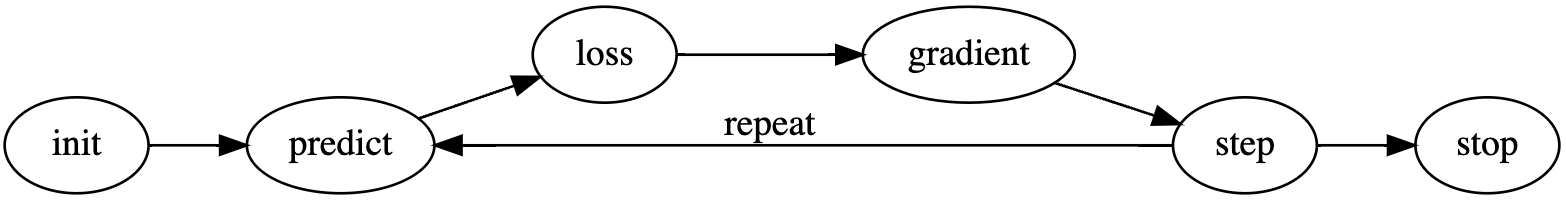

### 4 Steps in Deep Learning and Key Points

* **Multiple Approaches:** There are various ways to perform each of the seven steps in deep learning.

* **General Principles:** Despite various approaches, some general principles guide these steps:

    1. **Initialize:** Start with random weights for the parameters. While other initialization methods exist, random weights work well with weight improvement routines.
    2. **Loss:** Define a function that generates a small number for good model performance (convention: small loss = good, large loss = bad). This function reflects the model's effectiveness with the current weight assignment.
    3. **Step:** Update weights based on their impact on loss. A slow approach would involve manually adjusting weights (increase/decrease) based on loss changes. A more efficient approach using calculus (gradients) will be covered later.
    4. **Stop:** Determine a stopping criteria (e.g., number of epochs) for training the model. Stop training when accuracy worsens or time runs out (e.g., for our digit classifier).


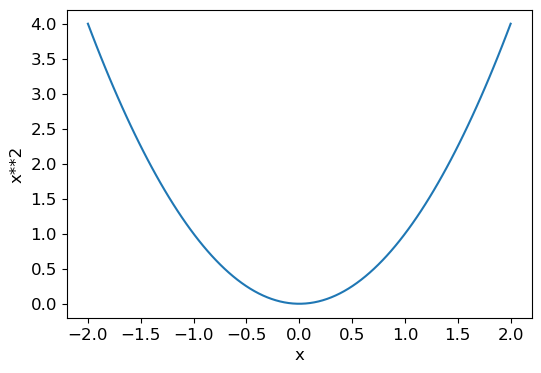

In [36]:
def f(x): return x**2

plot_function(f, 'x', 'x**2')

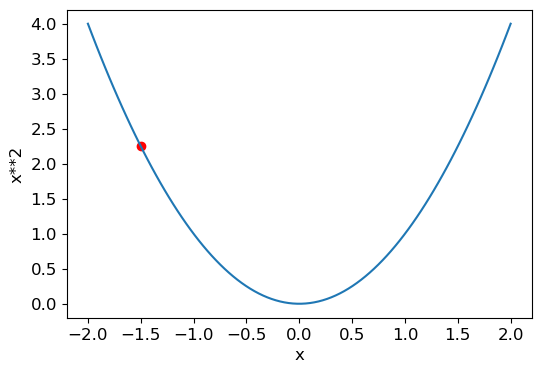

In [37]:
# The sequence of steps we described earlier starts by picking some random value for a parameter, and calculating the value of the loss:

plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

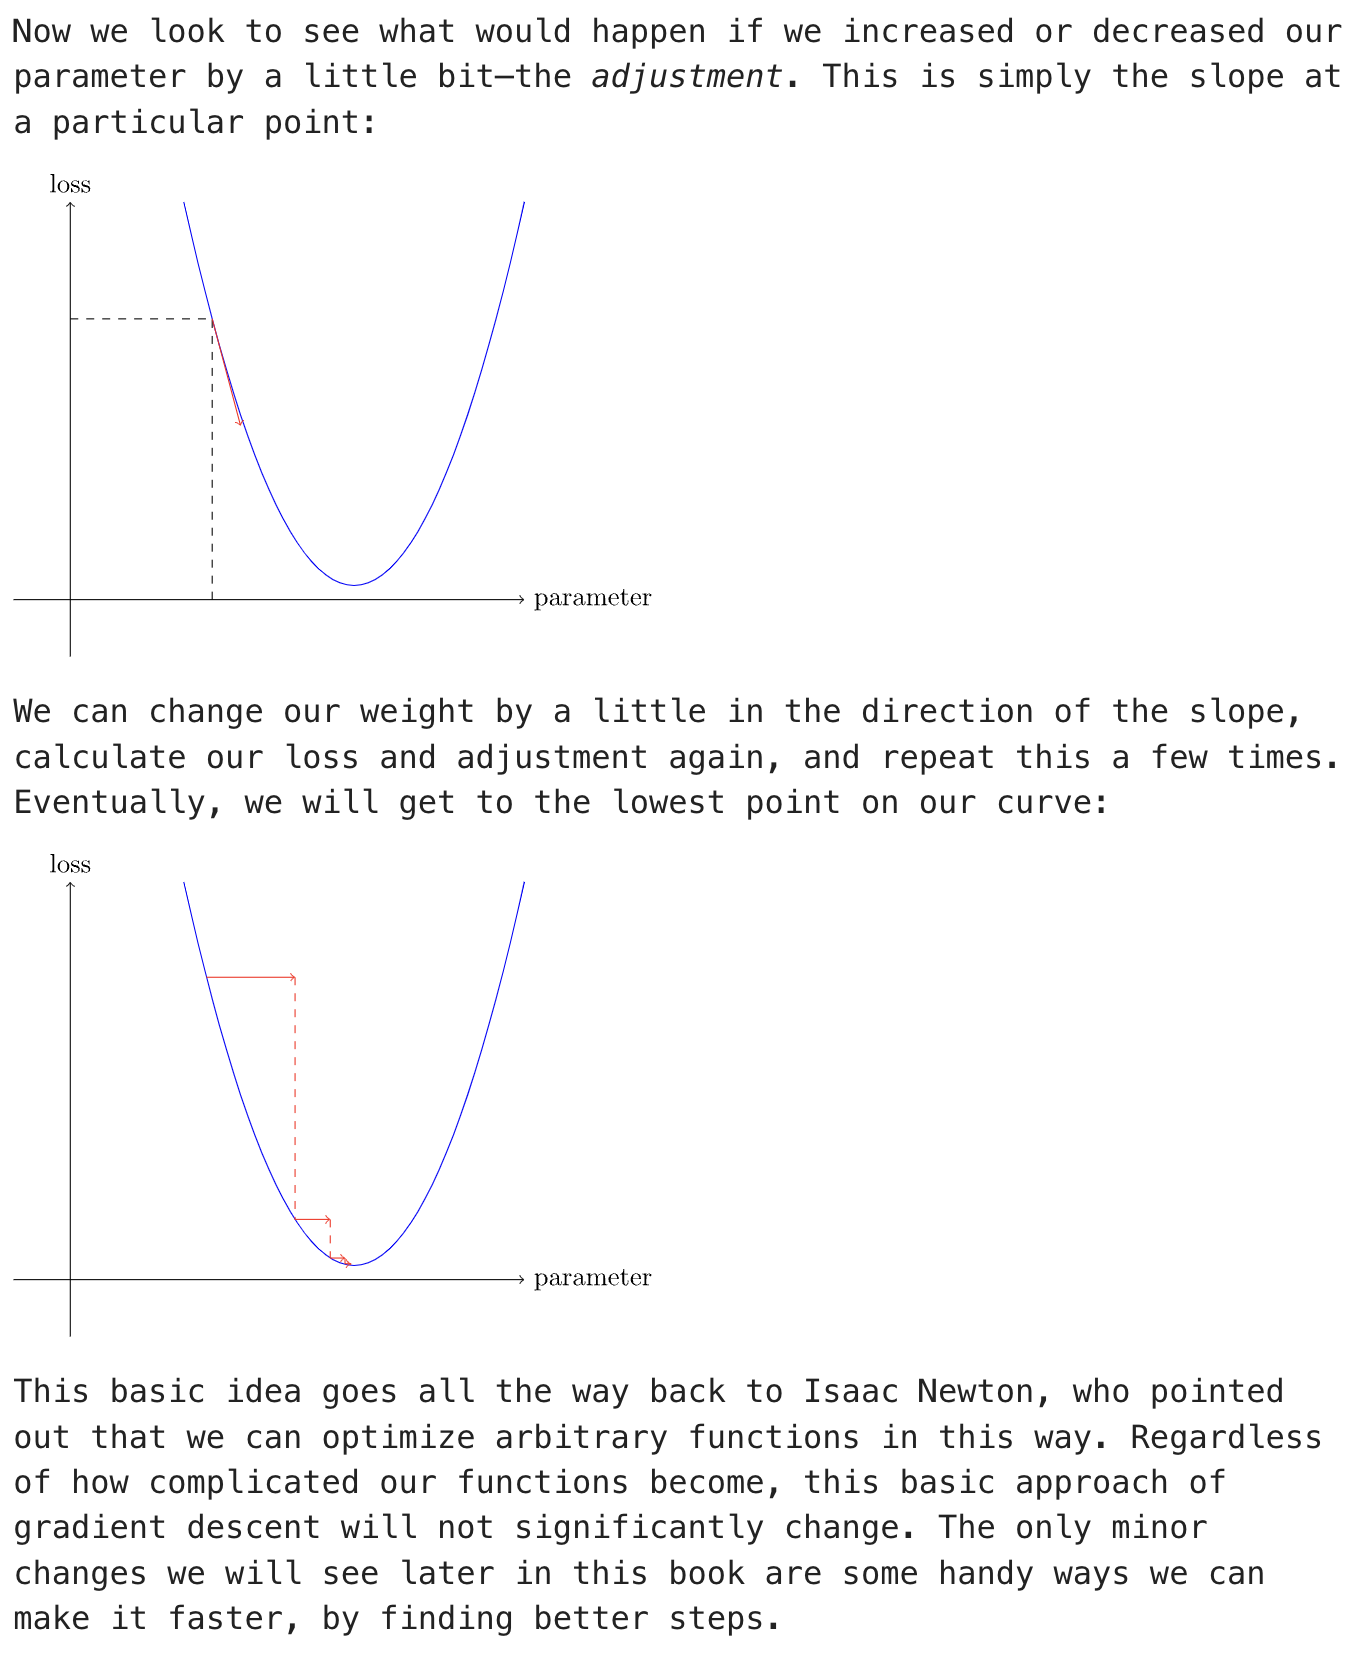

#### Gradients in Machine Learning

**Key Points:**

* **Importance:** Gradients are crucial for optimizing model performance.
* **Calculus as a Tool:** We leverage calculus to efficiently calculate how adjustments to model parameters affect the loss function (error).
* **Derivative as a Measure of Change:** The derivative, a concept from calculus, tells us how much the loss function changes based on a parameter change. (Understanding derivatives is recommended but not required for practical use.) 
* **Gradient Calculation:**
    * Similar to the slope in linear functions, the gradient represents the rate of change for a function. 
    * In machine learning, the gradient indicates how much each weight (parameter) in the model needs to be adjusted to minimize the loss function.
* **Multiple Gradients:** Since models have many weights, calculating the derivative results in multiple values - one for each weight. 
* **Automatic Calculation:** Fortunately, libraries like PyTorch can automatically compute these gradients efficiently, eliminating the need for manual calculations.


First, let's pick a tensor value which we want gradients at:

In [38]:

xt = tensor(3.).requires_grad_()

- **Understanding requires_grad_ method:**
  - Special method in PyTorch to calculate gradients for a variable at a specific value.
  - Tagging a variable notifies PyTorch to track gradients for subsequent calculations involving it.

- **API Perspective:**
  - Contrast with mathematical or physics contexts where "gradient" typically refers to a function's derivative.
  - In deep learning, "gradients" refer to derivative values at specific argument values.
  - PyTorch API emphasizes the argument, not the function itself, which may feel counterintuitive initially but offers a different perspective.

- **Function Evaluation:**
  - After tagging a variable, function evaluation in PyTorch incorporates gradient computation.
  - PyTorch outputs both the calculated value and notifies about the gradient function it will use for future gradient calculations.

In [39]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [40]:
# Finally, we tell PyTorch to calculate the gradients for us:
yt.backward()

- **Backward Pass in Deep Learning:**
  - **Definition:** "backward()" refers to backpropagation, the process of calculating derivatives for each layer.
  - **Calculation:** Done to obtain gradients of a deep neural network.
  - **Contrast:** Opposite of the "forward pass," where activations are computed.
- **Naming Convention:**
  - **Suggestion:** Naming it "calculate_grad" could simplify understanding.
  - **Observation:** Deep learning terminology tends to be intricate, favoring jargon.

In [41]:
# We can now view the gradients by checking the grad attribute of our tensor:
xt.grad

tensor(6.)

If you remember your high school calculus rules, the derivative of x**2 is 2*x, and we have x=3, so the gradients should be 2*3=6, which is what PyTorch calculated for us!

In [42]:
# Now we'll repeat the preceding steps, but with a vector argument for our function:

xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [43]:
# And we'll add sum to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [44]:
# Our gradients are 2*xt, as we'd expect!

yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters. But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

#### Gradients in Deep Learning

* **Importance:** Gradients are crucial for optimizing model performance in deep learning.
  * Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (LR).
  * Once you've picked a learning rate, you can adjust your parameters using this simple function:
    * `w -= gradient(w) * lr`
  * This is known as *stepping* your parameters, using an *optimizer step*
  * Notice how we subtract the `gradient * lr `from the parameter to update it. This allows us to adjust the parameter in the direction of the slope by increasing the parameter when the slope is negative and decreasing the parameter when the slope is positive. We want to adjust our parameters in the direction of the slope because our goal in deep learning is to minimize the loss.
* **Calculus as a Tool:** We leverage calculus to efficiently calculate how adjustments to model parameters will affect the loss function.
* **Understanding Derivatives:**
    * Gradients are essentially derivatives of the loss function with respect to each parameter (weight).
    * They indicate how much changing a parameter will affect the loss (increase or decrease).
    * A solid grasp of the concept of derivatives is recommended for further deep learning exploration (Khan Academy resources mentioned). 
* **Automatic Gradient Calculation:**
    * Fortunately, libraries like PyTorch can automatically compute gradients for most functions, saving us manual effort.
* **Learning Rate:**
    * This hyperparameter controls the step size taken during parameter updates based on the gradients.
    * Choosing an appropriate learning rate is essential:
        * Too low: slow convergence (many steps needed)
            * 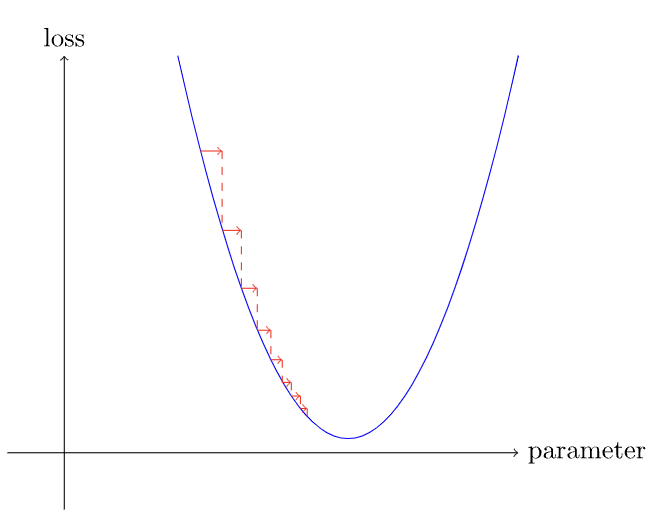
        
        
        * Too high: potential for divergence or erratic behavior
            * 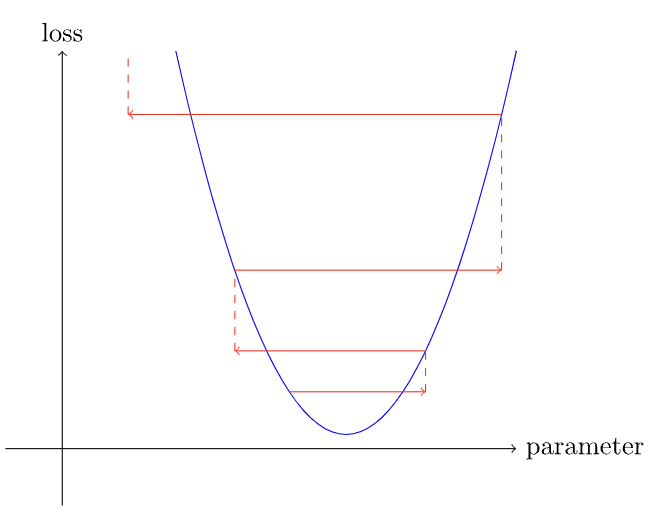
        * Good enough: smooth convergence
            * 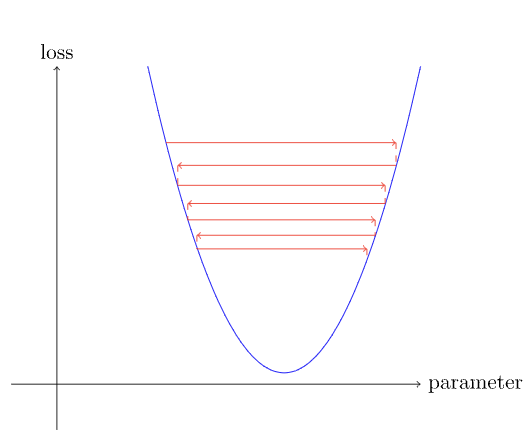

**An End-to-End SGD Example:**

- Introduction to using gradients to find a minimum and training a model.
- Example scenario: Consider this process as figuring out the speed of a roller coaster over time.
  - Description of the speed pattern: Starts fast, slows at the top, then speeds up downhill.
- Goal: Build a model to represent the speed changes over a 20-second period.

In [45]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

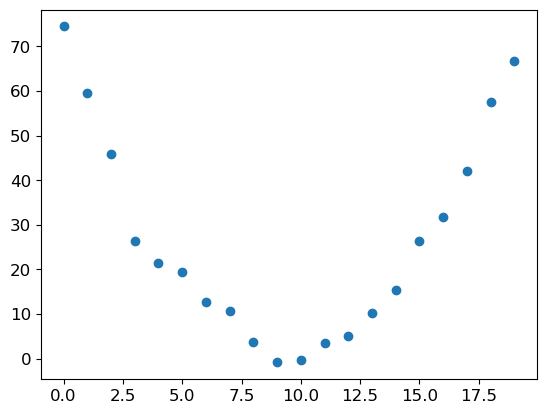

In [46]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

- Added random noise to measurements due to manual imprecision.
- Difficulty in determining roller coaster's speed precisely.
- Utilizing Stochastic Gradient Descent (SGD) to find a fitting function.
- Considering a quadratic function
  - 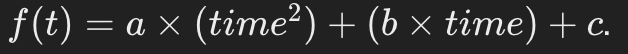
- Parameters separated from input: *t* (time) and *params* (for quadratic function parameters).

In [47]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

- **Objective in Function Fitting:**
  - Simplify the problem by restricting it to finding the best quadratic function.
  - Quadratic functions defined by three parameters: a, b, and c.
  - Task is to find the optimal values for a, b, and c to obtain the best quadratic function.
  - This approach is applicable to more complex functions with additional parameters, such as neural networks.
  - Once parameters for quadratic function are determined, similar method can be applied to other functions.

- **Defining "Best" with Loss Function:**
  - "Best" precisely defined by selecting a loss function.
  - Loss function evaluates prediction against target, lower values indicating better predictions.
  - Importance of loss functions: SGD aims to minimize this loss.
  
- **Common Loss Function for Continuous Data:**
  - Mean squared error often used for continuous data.

In [48]:
def mse(preds, targets): return ((preds-targets)**2).mean()
     

Now, let's work through our 7 step process.

#### Step 1: Initialize the parameters
First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using `requires_grad_`:

In [49]:
params = torch.randn(3).requires_grad_()
orig_params = params.clone()

#### Step 2: Calculate the predictions
Next, we calculate the predictions:

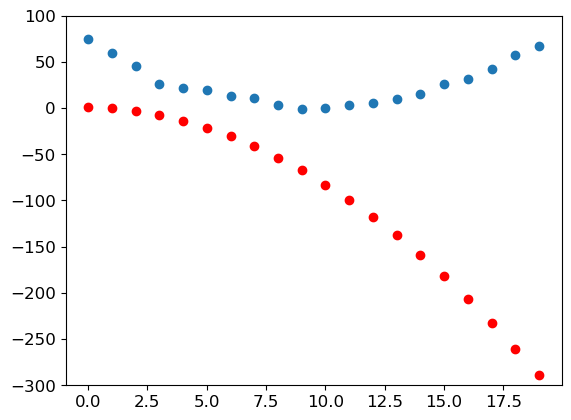

In [50]:
preds = f(time, params)


#Let's create a little function to see how close our predictions are to our targets, and take a look:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

show_preds(preds)

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

#### Step 3: Calculate the loss
We calculate the loss as follows:

In [51]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we'll need to know the gradients.

#### Step 4: Calculate the gradients
The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

In [52]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [53]:
params.grad * 1e-5     

tensor([-0.5320, -0.0342, -0.0025])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

In [54]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### Step 5: Step the weights.
Now we need to update the parameters based on the gradients we just calculated:

In [55]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

- Gradients are calculated by calling backward on the loss.
- Loss is computed via mean squared error (mse), which takes predictions (preds) as input.
- Predictions are derived from a function (f) operating on parameters (params).
- Parameters are set to require gradients (requires_grad_) initially, facilitating backward calls on the loss.
- This sequence of function calls embodies the mathematical composition of functions.
- PyTorch utilizes the chain rule of calculus to efficiently compute gradients.


tensor(5435.5356, grad_fn=<MeanBackward0>)


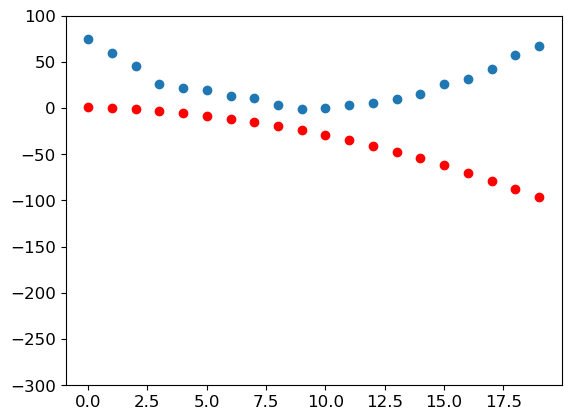

In [56]:
# Let's see if the loss has improved:

preds = f(time,params)
print(mse(preds, speed))

show_preds(preds)

In [57]:
# We need to repeat this a few times, so we'll create a function to apply one step:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process
Now we iterate. By looping and performing many improvements, we hope to reach a good result:

In [58]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023193359375
676.9645385742188
676.9537353515625


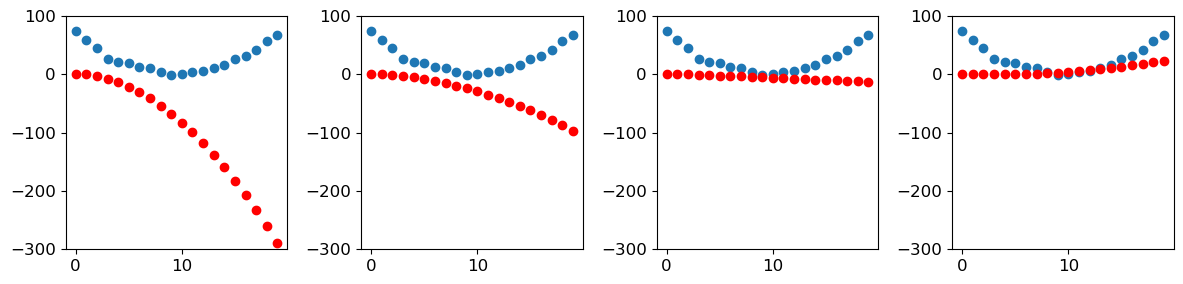

In [59]:
params = orig_params.detach().requires_grad_()

_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

#### Step 7: stop

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

### Summarizing Gradient Descent

- **Model Initialization:**
  - Weights of the model can be random (training from scratch) or from a pretrained model (transfer learning).
  - Initial weights may not yield desired outputs, necessitating weight adjustments.

- **Loss Calculation:**
  - Compare model outputs with targets using a loss function to quantify the deviation.
  - Labeled data allows evaluation of model performance against known targets.
  - Objective is to minimize the loss function by improving weights.

- **Gradient Descent:**
  - Utilize calculus (or PyTorch) to compute gradients, indicating direction and magnitude of weight adjustments.
  - Analogous to navigating a landscape to find the lowest point (parking lot) where the car (model) is located.
  - Adjust weights iteratively, moving in the direction of steepest descent, determined by gradients.
  - Learning rate determines step size in weight adjustment process.

- **MNIST Dataset Example:**
  - Transposable concepts to MNIST dataset.
  - Exception: Definition of a suitable loss function tailored to the dataset.

## The MNIST Loss Function

We already have our independent variables `x`—these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using `view`, which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data":

In [60]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
     
# We need a label for each image. We'll use 1 for 3s and 0 for 7s:

train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [61]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
print("Shape of X:", x.shape)
print("Shape of y:", y.shape)

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

# Now we need an (initially random) weight for every pixel (this is the initialize step in our seven-step process):

def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
     
weights = init_params((28*28,1))

Shape of X: torch.Size([784])
Shape of y: torch.Size([1])


The function `weights*pixels` won't be flexible enough— it is always equal to 0 when the pixels are equal to 0 (i.e., its intercept is 0). 

the formula for a line is y=w*x+b; we still need the b. We'll initialize it to a random number too. 

In neural networks, the `w` in the equation *y=w*x+b* is called the *weights*, and the b is called the *bias*. Together, the *weights* and *bias* make up the parameters.

In [62]:
bias = init_params(1)

# We can now calculate a prediction for one image:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

Python `for` loops are Slow for Image Classification

* **Loop-based calculations are inefficient:**
    * Python loops are slow for numerical computations, especially when compared to vectorized operations.
    * Loops don't leverage GPUs for processing, further hindering performance.

* **Solution: Utilize Higher-Level Functions and Matrix Multiplication**
    * Represent computations using mathematical operations for efficiency.
    * Matrix multiplication is a particularly efficient way to perform calculations on entire matrices simultaneously.

* **Resource for Refreshing Matrix Multiplication:**
    * Khan Academy's Intro to [Matrix Multiplication](https://www.khanacademy.org/math/algebra-home/alg-matrices) is recommended for a review as it's a fundamental concept in deep learning.


In [63]:
# In Python, matrix multiplication is represented with the @ operator. Let's try it:

def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

The first element is the same as we calculated before, as we'd expect. This equation, `batch@weights + bias`, is one of the two fundamental equations of any neural network (the other one is the activation function, which we'll see in a moment).

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [64]:
corrects = (preds>0.0).float() == train_y
print(corrects)

print("The mean ", corrects.float().mean().item())

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])
The mean  0.4912068545818329


In [65]:
"""
Now let's see what the change in accuracy is for a small change in one of the weights 
(note that we have to ask PyTorch not to calculate gradients as we do this, which is what with torch.no_grad() is doing here):
"""

with torch.no_grad(): weights[0] *= 1.0001

preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329


- **Gradients and Loss Function:**
  - Gradients are necessary for model improvement via SGD.
  - Loss function represents model performance.
  - Gradients are a measure of how that loss function changes with small tweaks to the weights.

- **Choosing a Loss Function:**
  - Accuracy seems intuitive as a loss function.
    - we can calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.
  - Issue arises: Accuracy changes only with specific prediction shifts (e.g., 3 to 7).
    - The gradient of a function is its slope, or its steepness, which can be defined as rise over run—that is, how much the value of the function goes up or down, divided by how much we changed the input. 
    - `(y_new - y_old) / (x_new - x_old)`
    - A good approximation of the gradient when `x_new` is very similar to `x_old`, meaning that their difference is very small. 
    - But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa. The problem is that a small change in weights from `x_old` to `x_new` isn't likely to cause any prediction to change, so `(y_new - y_old)` will almost always be 0. In other words, the gradient is 0 almost everywhere.
  - Gradually changing weights often don't affect accuracy.
  - Accuracy's derivative is mostly zero, rendering gradients ineffective.
    -  In mathematical terms, accuracy is a function that is constant almost everywhere (except at the threshold, 0.5), so its derivative is nil almost everywhere (and infinity at the threshold). This then gives gradients that are 0 or infinite, which are useless for updating the model.

- **Limitations of Accuracy as a Loss Function:**
  - Accuracy's derivative is nil almost everywhere.
  - Gradients become either 0 or infinite, not useful for model updates.

- **Need for an Effective Loss Function:**
  - Loss function should reflect small improvements in predictions.
  - "Slightly better prediction" involves higher score for correct predictions.

- **Formulating a New Loss Function:**
  - Loss function operates on model predictions, not raw images.
  - Takes predictions (prds) and targets (trgts), both vectors (rank-1 tensors).
  - Measures the difference between predicted and true values.

- **Loss Function Structure:**
  - Receives predictions (prds) between 0 and 1.
  - Targets (trgts) are binary (0 or 1), indicating if an image is a 3.

- **Purpose of the Loss Function:**
  - Evaluate how well predictions match the true labels.
  - Quantify the discrepancy between predicted and actual values.

In [66]:
# consider the images to be 3, 7, 3. If we want the model to predict 3 correctly, the target should be 1,0, 1. Here, 1 represnts True labels. 
trgts  = tensor([1,0,1])

# Now, suppose our model predicts the following 0.9, 0.4, 0.2.  We can see 0.9 is close to 1, but 0.2 is not close to 1. 
# So, it means the model has not correctly predicted the 3rd 3. 
prds   = tensor([0.9, 0.4, 0.2])

- `torch.where(a, b, c)` function overview:
  - Performs similar operation as the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`.
  - Works on tensors and operates at C/CUDA speed, unlike Python loops over tensors.
  - Measures the distance of each prediction from 1 if it should be 1, and from 0 if it should be 0.
  - Computes the mean of all these distances.
- Importance of learning PyTorch functions:
  - Looping over tensors in Python operates at Python speed, not C/CUDA speed.
  - Refer to PyTorch documentation or use `help(torch.where)` to understand its usage and benefits.

In [67]:
# Here's a first try at a loss function that measures the distance between predictions and targets:

def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()


# Let's try it on our prds and trgts:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [68]:
"""You can see that this function returns a lower number when predictions are more accurate, 
when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. 
In PyTorch, we always assume that a lower value of a loss function is better. 
Since we need a scalar for the final loss, mnist_loss takes the mean of the previous tensor:
"""
print("Loss: ",  mnist_loss(prds,trgts))



Loss:  tensor(0.4333)


For instance, if we change our prediction for the one "false" target from 0.2 to 0.8 the loss will go down, indicating that this is a better prediction:

In [69]:
preds_new =  [0.9, 0.4, 0.8]
print("New loss: ", mnist_loss(tensor(preds_new),trgts))

New loss:  tensor(0.2333)


One problem with mnist_loss as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.

#### Sigmoid Function

**What it Does:**

* Outputs a value between 0 and 1, regardless of the input.

**Formula:**

* `sigmoid(x) = 1 / (1 + torch.exp(-x))` (Implemented efficiently in PyTorch)

**Importance:**

* Ensures values are between 0 and 1, often desired in deep learning tasks.

**Visualization:**
* Takes any input (positive or negative) and "squishes" it to an output between 0 and 1.
* Smooth curve with a gradual increase, beneficial for optimization algorithms.

**Additional Notes:**

* PyTorch provides an optimized version, so implementing your own is generally unnecessary.
* The smooth, increasing curve makes it easier for Stochastic Gradient Descent (SGD) to find meaningful gradients during training.


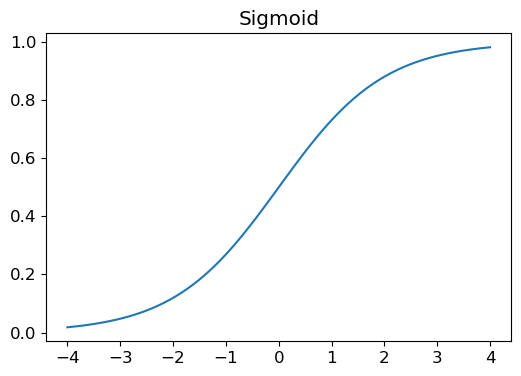

In [70]:
# defining sigmoid function:
def sigmoid(x): return 1/(1+torch.exp(-x))

# Lets plot out sigmoid function
plot_function(sigmoid, title='Sigmoid', min=-4, max=4)

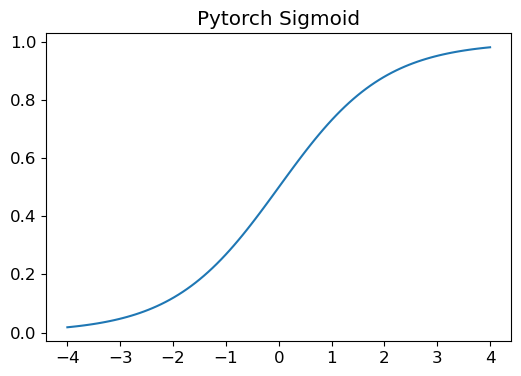

In [71]:
# Pytorch defines an accelerated version for us, so we don’t really need our own
plot_function(torch.sigmoid, title='Pytorch Sigmoid', min=-4, max=4)

In [72]:
# Let's update mnist_loss to first apply sigmoid to the inputs:

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Loss vs. Metric in Image Classification

* **Loss Function:** 
    * Ensures gradients exist for training (important for optimization algorithms).
    * May not directly reflect the desired outcome but is optimized for training.
    * Calculated per item and averaged for an epoch.

* **Metric (e.g., Accuracy):**
    * Reflects actual model performance on the task (human understandable).
    * Used for evaluating model performance, not directly in training.
    * Reported at the end of each epoch.

**In summary:**

* Loss function guides model training (helps the model learn).
* Metric reflects how well the model performs (helps us understand the model's performance).


#### SGD and Mini-Batches: Key Points

* **Mini-Batch SGD:**  We calculate the loss function over a small subset of data (mini-batch) for optimization steps (updating weights) during SGD.

* **Benefits of Mini-Batches:**
  * **Balance between Accuracy and Efficiency:**
    - Using the entire dataset is slow.
    - Using a single data point is inaccurate and unstable for gradient updates.
    - Mini-batches provide an accurate estimate while being faster than full dataset calculations.
  * **Better GPU Utilization:** GPUs perform well with larger workloads. Mini-batches provide sufficient data for efficient GPU usage.

* **Batch Size:** The number of data items in a mini-batch.
  * Larger batch size:
    * More accurate and stable gradients.
    * Slower training due to fewer mini-batches per epoch.
  * Choosing an optimal batch size is crucial for efficient and accurate training.

* **Random Shuffling:** Improves generalization by varying data within mini-batches during each epoch.

* **DataLoader:** A class (PyTorch/fastai) that simplifies data shuffling and mini-batch creation from a given dataset. 


In [73]:
# A DataLoader can take any Python collection and turn it into an iterator over mini-batches, like so:

coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [74]:
"""
For training a model, we don't just want any Python collection,
but a collection containing independent and dependent variables (that is, the inputs and targets of the model). 
A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset. 
Here's an example of an extremely simple Dataset:"""
ds = L(enumerate(string.ascii_lowercase))
print(ds)

# When we pass a Dataset to a DataLoader we will get back mini-batches which are themselves tuples of tensors representing batches of independent and dependent variables:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)
     

[(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd'), (4, 'e'), (5, 'f'), (6, 'g'), (7, 'h'), (8, 'i'), (9, 'j'), (10, 'k'), (11, 'l'), (12, 'm'), (13, 'n'), (14, 'o'), (15, 'p'), (16, 'q'), (17, 'r'), (18, 's'), (19, 't'), (20, 'u'), (21, 'v'), (22, 'w'), (23, 'x'), (24, 'y'), (25, 'z')]


[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

We are now ready to write our first training loop for a model using SGD!
    
**Putting It All Together**
It's time to implement the process we saw in gradient_descent. In code, our process will be implemented something like this for each epoch:


    for x,y in dl:
        pred = model(x)
        loss = loss_func(pred, y)
        loss.backward()
        parameters -= parameters.grad * lr


In [75]:
# First, let's re-initialize our parameters:
weights = init_params((28*28,1))
bias = init_params(1)
     
# A DataLoader can be created from a Dataset:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
print("Shape of X and y", xb.shape,yb.shape)

# We'll do the same for the validation set:
valid_dl = DataLoader(valid_dset, batch_size=256)

# Let's create a mini-batch of size 4 for testing:
batch = train_x[:4]
print("Batch shape: ", batch.shape)

preds = linear1(batch)
print("Preds: ", preds)

loss = mnist_loss(preds, train_y[:4])
print("loss: ", loss)

# Now we can calculate the gradients:
loss.backward()
print("Calculating gradients: ", weights.grad.shape,weights.grad.mean(),bias.grad)

Shape of X and y torch.Size([256, 784]) torch.Size([256, 1])
Batch shape:  torch.Size([4, 784])
Preds:  tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)
loss:  tensor(0.7419, grad_fn=<MeanBackward0>)
Calculating gradients:  torch.Size([784, 1]) tensor(-0.0061) tensor([-0.0420])


In [76]:
# Let's put that all in a function:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

# and test it:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0121), tensor([-0.0840]))

In [77]:
# But look what happens if we call it twice:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0182), tensor([-0.1260]))

The gradients have changed after we called it twice! 
The reason for this is that `loss.backward` actually adds the gradients of `loss` to any gradients that are currently stored. 
So, we have to set the current gradients to 0 first:

In [78]:

weights.grad.zero_()
bias.grad.zero_();

**Inplace Operations:** 
- Methods in PyTorch whose names end in an underscore modify their objects in place. 
- For instance, `bias.zero_()` sets all elements of the tensor `bias` to 0.


Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the data attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [79]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

# We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:
(preds>0.0).float() == train_y[:4]             

tensor([[False],
        [False],
        [ True],
        [False]])

In [80]:
# That gives us this function to calculate our validation accuracy:


def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

print("Batch accuracy: ", batch_accuracy(linear1(batch), train_y[:4]))

# and then put the batches together:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)
validate_epoch(linear1)
     

Batch accuracy:  tensor(0.2500)


0.5264

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

In [81]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6663

In [82]:
# Then do a few more:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8265 0.89 0.9183 0.9276 0.9398 0.9466 0.9505 0.9525 0.9559 0.9578 0.9598 0.9608 0.9613 0.9618 0.9633 0.9637 0.9647 0.9657 0.9672 0.9677 

Looking good! We're already about at the same accuracy as our "pixel similarity" approach, and we've created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. 

In PyTorch, it's called an `optimizer`.

#### Creating an Optimizer 
**Using nn.Linear in PyTorch Model**

* **PyTorch's nn.Linear Module:** 
    * Simplifies model creation by combining weight and bias operations.
    * Inherits from the `nn.Module` class.

* **nn.Linear vs. Custom Linear Function:**
    * `nn.Linear` replaces both `init_params` and `linear` functions.
    * It encapsulates both weights and biases within a single class.

* **Benefits:**
    * Cleaner and more concise model representation.
    * Potentially more efficient implementation by PyTorch.


In [83]:
# nn.Linear does the same thing as our init_params and linear together. 
# It contains both the weights and biases in a single class. Here's how we replicate our model from the previous section:

linear_model = nn.Linear(28*28,1)

# Every PyTorch module knows what parameters it has that can be trained; they are available through the parameters method:
w,b = linear_model.parameters()
print("Shape: ", w.shape,b.shape)

Shape:  torch.Size([1, 784]) torch.Size([1])


In [84]:
# We can use this information to create an optimizer:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

# We can create our optimizer by passing in the model's parameters:
opt = BasicOptim(linear_model.parameters(), lr)

In [85]:
# Our training loop can now be simplified to:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()
     
# Our validation function doesn't need to change at all:
validate_epoch(linear_model)

0.4606

In [86]:
# Let's put our little training loop in a function, to make things simpler:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')
     
# The results are the same as in the previous section:
train_model(linear_model, 20)     

0.4932 0.7686 0.8554 0.9136 0.9346 0.9482 0.957 0.9634 0.9658 0.9678 0.9697 0.9717 0.9736 0.9746 0.9761 0.977 0.9775 0.9775 0.978 0.9785 

In [87]:
# fastai provides the SGD class which, by default, does the same thing as our BasicOptim:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8179 0.8496 0.914 0.9346 0.9482 0.957 0.9619 0.9658 0.9673 0.9692 0.9712 0.9741 0.9751 0.9761 0.9775 0.9775 0.978 0.9785 0.979 

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation DataLoaders:

In [88]:
dls = DataLoaders(dl, valid_dl)
     

To create a `Learner` without using an application (such as `vision_learner`) we need to pass in all the elements that we've created in this chapter: 
- the `DataLoaders`, 
- the model, 
- the optimization function (which will be passed the parameters), 
- the loss function, and 
- optionally any metrics to print:

In [89]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)


# Now we can call fit:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636709,0.503144,0.495584,00:00
1,0.429828,0.248517,0.777233,00:00
2,0.161680,0.155361,0.861629,00:00
3,0.072948,0.097722,0.917566,00:00
4,0.040128,0.073205,0.936212,00:00
5,0.027210,0.059466,0.950442,00:00
6,0.021837,0.050799,0.957802,00:00
7,0.019398,0.044980,0.964181,00:00
8,0.018122,0.040853,0.966143,00:00
9,0.017330,0.037788,0.968106,00:00


#### Nonlinearity
- Introduction to Nonlinearity:
  - Procedure for optimizing function parameters established.
  - Initial application on linear classifier, limited in capability.
  - Nonlinearity essential for enhancing complexity and task versatility.

- Basic Neural Network Definition:
  - Comprises linear classifiers with nonlinear element in between.
  - Nonlinear component crucial for enabling neural network functionality and flexibility.

In [90]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

#That's it! All we have in simple_net is two linear classifiers with a max function between them.

In [91]:
# Here, w1 and w2 are weight tensors, and b1 and b2 are bias tensors; 
# that is, parameters that are initially randomly initialized, just like we did in the previous section:


w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

- **PyTorch's Layer Output:**
  - `w1` has 30 output activations.
  - `w2` must have 30 input activations to match.
  - First layer constructs 30 different features, representing various pixel mixes.
  - Model complexity can be adjusted by changing the number of output activations (30 in this case).

- **Rectified Linear Unit (ReLU):**
  - `res.max(tensor(0.0))` is a rectified linear unit (ReLU).
  - ReLU replaces every negative number with zero.
  - Simplified as `F.relu` in PyTorch.

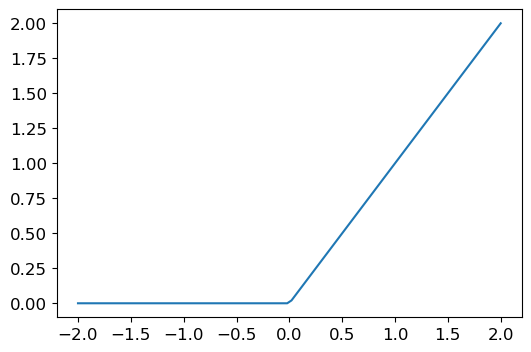

In [92]:

plot_function(F.relu)

- **Linear Layers:**
  - Using more linear layers allows the model to perform more computation.
  - Stacking linear layers directly may not be beneficial, as they can be replaced by a single linear layer with different parameters.

- **Nonlinear Functions:**
  - Introducing nonlinear functions (e.g., max) between linear layers allows for more complex modeling.
  - Each linear layer becomes somewhat decoupled, enabling independent useful work.

- **Composition of Linear Functions:**
  - Mathematically, composing two linear functions results in another linear function.
  - Stacking linear classifiers without nonlinear functions behaves as one linear classifier.

- **Universal Approximation Theorem:**
  - Proven that a combination of linear layers and nonlinear activations can approximate any computable problem.
  - Using shorter lines (more parameters) improves approximation.
  - The three lines of code represent layers: two linear layers and one activation function.

In [93]:
# Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

- `nn.Sequential`:
  - Creates a module that sequentially calls each listed layer or function.
  - When using `nn.Sequential`, PyTorch requires the module version of functions.
  - Modules are instantiated as classes, hence `nn.ReLU()` is used instead of `F.relu()` within `nn.Sequential`.

- `nn.ReLU`:
  - PyTorch module equivalent to the `F.relu` function.
  - Most functions in models have identical module forms, replacing `F` with `nn` and adjusting capitalization.

- Getting Parameters:
  - `nn.Sequential` being a module allows access to its parameters.
  - Calling `parameters()` on `nn.Sequential` returns a list of parameters from all its contained modules.

- Deeper Models:
  - When dealing with deeper models, consider adjusting hyperparameters like learning rate and epochs.
  - Lower learning rates and more epochs might be suitable for deeper models to ensure convergence.

In [94]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [95]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.333021,0.396112,0.512267,00:00
1,0.152461,0.235238,0.797350,00:00
2,0.083573,0.117471,0.911678,00:00
3,0.054309,0.078720,0.940628,00:00
4,0.040829,0.061228,0.956330,00:00
5,0.034006,0.051490,0.963690,00:00
6,0.030123,0.045381,0.966634,00:00
7,0.027619,0.041218,0.968106,00:00
8,0.025825,0.038200,0.969087,00:00
9,0.024441,0.035901,0.969578,00:00


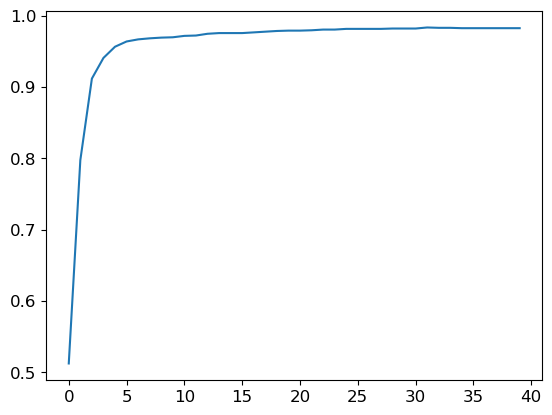

In [96]:
"""We're not showing the 40 lines of output here to save room; 
the training process is recorded in learn.recorder, with the table of output stored in the values attribute, 
so we can plot the accuracy over training as:"""

plt.plot(L(learn.recorder.values).itemgot(2));

In [97]:
learn.recorder.values[-1][2]

0.98233562707901

- PyTorch enables the creation of neural networks capable of solving problems to any desired level of accuracy.
- Neural networks, functioning as a "magic" function, can solve various problems given the correct parameters.
- Stochastic gradient descent facilitates finding the optimal parameters for any function.
- Deep learning achieves seemingly magical feats due to the synergy of neural networks and stochastic gradient descent.
- The simplicity and effectiveness of these techniques may seem too good to be true for some.
- Encouragement to experiment and verify the effectiveness by trying out PyTorch on datasets like MNIST.
- Assures transparency by stating that the process involves no hidden magic, as everything is implemented from scratch except for gradient calculations.


### Going Deeper with Neural Networks (.md)

* **Deep vs. Shallow Networks:**
    * We can add more than two linear layers to create deeper models. 
    * Non-linearity is added between each pair of linear layers.
    * Deeper models can be harder to optimize during training.

* **Benefits of Deeper Models:**
    * **Improved Performance:** Deeper models can achieve better results compared to shallow models with fewer layers, even using less parameters overall.
    * **Faster Training & Lower Memory Usage:** Training deeper models can be faster and require less memory compared to shallow models with a large number of parameters.

* **Historical Context:**
    * In the 1990s, focus on the universal approximation theorem limited exploration of deeper models.
    * While theoretically sound, this limited practical advancements in the field for some time.
    * Some researchers continued experimenting with deep models, demonstrating their practical advantages.

* **Modern Practices:**
    * Today, neural networks with just one non-linearity are rarely used.



In [98]:
# Here is what happens when we train an 18-layer model using the same approach we saw in ch1.introduction.ipynb:


dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.079946,0.023002,0.995584,00:26


**Nearly 100% accuracy!** That's a big difference compared to our simple neural net. But as you'll learn in the remainder of this book, there are just a few little tricks you need to use to get such great results from scratch yourself. You already know the key foundational pieces. (Of course, even once you know all the tricks, you'll nearly always want to work with the pre-built classes provided by PyTorch and fastai, because they save you having to think about all the little details yourself.)

## Chapter Recap and Key Concepts

**Neural Network Numbers:**

* **Activations:** Numbers calculated during the forward pass (both linear and non-linear layers).
* **Parameters:** Numbers randomly initialized and optimized during training (define the model).

**Tensors and Dimensions:**

* Tensors: Regularly shaped arrays (like matrices) containing activations and parameters.
    * Rank 0: Scalar
    * Rank 1: Vector
    * Rank 2: Matrix
    * Higher ranks possible

**Network Layers:**

* **Linear Layers:** Perform matrix multiplication and bias addition.
* **Non-linear Layers:** Apply non-linear activation functions (e.g., ReLU).
* Layers are often alternated between linear and non-linear types.
    * Note: Terminology can be confusing (linear layer + non-linearity = single layer).
